#### This notebook is post-processing curvature points to extract the approximate location of the corners.

The information extracted from the curvature are noisy. The goal is too group the noisy points into regions, where approximately the corners are.

In [38]:
import pandas as pd
import numpy as np

In [39]:
points = pd.read_csv("/Users/valentina/projects/cornea_project/Lepto/processed/thesholded_curvature.csv")

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
# old version 0.04 - 0.05
# 0.037 - 0.05 cannot finish in spectral clustering
points.Gauss_Curvature.max()
points_subset = points[points['Gauss_Curvature'].between(0.03,0.05)]
#points_subset = points[points['Gauss_Curvature'].between(0.0,10)]
points_subset.shape

(5672, 7)

In [42]:
points_subset.head()

,Normals:0,Normals:1,Normals:2,Gauss_Curvature,Points:0,Points:1,Points:2
15,-0.023593,0.22020,0.97517,0.045961,635.0,687.0,11.9
22,0.289240,0.37470,-0.88087,0.031365,468.2,423.0,13.0
30,-0.152880,-0.36779,-0.91726,0.032787,684.0,454.9,14.0
31,-0.173090,-0.35505,-0.91869,0.040997,683.8,455.0,14.0
42,0.063596,0.38158,0.92215,0.047311,643.0,686.0,14.5


### K Means clustering

In [43]:
from sklearn.cluster import KMeans
X = points_subset[["Points:0","Points:1","Points:2"]]
kmeans = KMeans(n_clusters = 200,random_state=0).fit(X)
labels = kmeans.labels_
labels.astype(np.float)
print(len(labels))

5672


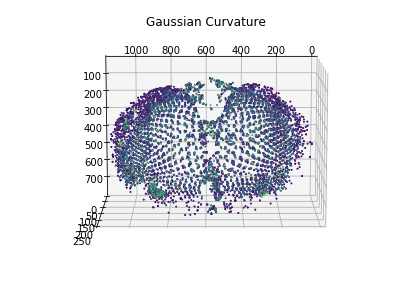

In [7]:
# plot the points covered by curvature
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points["Points:0"], points["Points:1"],points["Points:2"], c=np.array(points["Gauss_Curvature"]), s=0.5, cmap='viridis')
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(100, 90)
plt.title('Gaussian Curvature')
plt.show()

In [107]:
# unnecessary colormap stuff
#
cmap = plt.get_cmap('rainbow',len(set(labels)))
colors = [cmap(l) for l in labels]
np.array(colors).shape
colors = [int(i % 23) for i in labels]
labels.astype(np.float)


import matplotlib as mpl

N = 200
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
(labels).astype(np.int)
print(len(labels))

labels.shape


33618


(33618,)

<IPython.core.display.Javascript object>


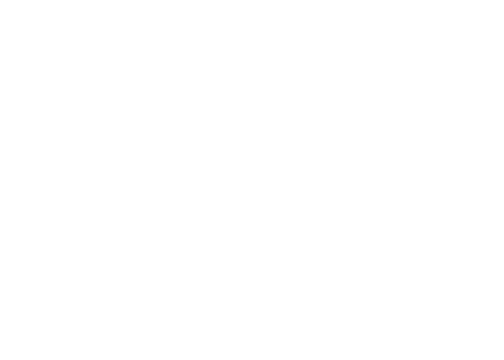

In [108]:
# kmeans clustering
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(points_subset["Points:0"]), np.array(points_subset["Points:1"]),np.array(points_subset["Points:2"]), c=labels, s=0.5,cmap = "viridis")
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(100, 90)
plt.title('K-Means Clusters')
plt.show()

# colormap does not work: keeping getting invalid RGBA error

In [109]:
#kmeans.cluster_centers_

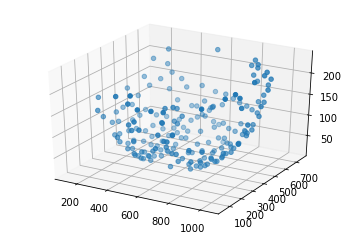

In [11]:
# plot the centers
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2])

### Nearest Neighbor Graph and Spectral Clustering

In [12]:
# finding the nearest neighbors
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [13]:
# creating the nearest neighbor graph
G = nbrs.kneighbors_graph(X, mode='distance').toarray()

In [14]:
G.shape

(1916, 1916)

In [15]:
# spectral clustering
from sklearn import cluster
spectral = cluster.SpectralClustering(n_clusters=20, eigen_solver='arpack',affinity="nearest_neighbors")
spectral.fit(X)

/Users/valentina/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
          gamma=1.0, kernel_params=None, n_clusters=20, n_init=10,
          n_jobs=1, n_neighbors=10, random_state=None)

In [16]:
labels = spectral.labels_

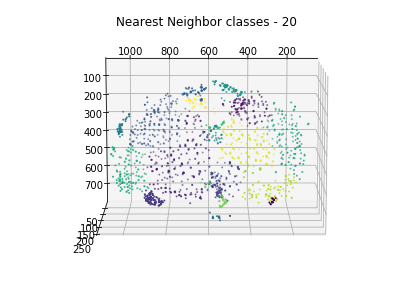

In [17]:
# create colors for the visualization
from itertools import cycle, islice
spectral.labels_
y_pred = spectral.labels_.astype(np.int)
# colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
#                                             '#f781bf', '#a65628', '#984ea3',
#                                             '#999999', '#e41a1c', '#dede00']),
#                                      int(max(y_pred) + 1))))
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_subset["Points:0"], points_subset["Points:1"],points_subset["Points:2"], s=1, c=spectral.labels_)
ax.view_init(100, 90)
plt.title("Nearest Neighbor classes - 20")
plt.show()

In [18]:
# from sklearn.neighbors import RadiusNeighborsClassifier
# radius_nbrs = RadiusNeighborsClassifier(radius=1.0)
# radius_nbrs.radius_neighbors_graph(X)

#### Radius Nearest Neighbors

The radius nearest neighbors might be a better choice in this case. 

In [19]:
from sklearn.neighbors import radius_neighbors_graph
G = radius_neighbors_graph(X,5,mode='connectivity',include_self=True)
print(G.shape)
G.toarray()

(1916, 1916)


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

The connectivity matrix is big but mainly contains zeros and ones. Spectral Clustering has different methods to solve the linear algebra problem:
* it can accept a precomputed sparse matrix
* default 'arpack'
* the 'amg' method is supposed to work well with large and sparse but requires pyamg package installed sometimes returns a numerical error

In [20]:
# If you do not have pyamg installed, uncomment next two cells

In [21]:
# !conda install --yes pyamg

In [22]:
# import pyamg

In [23]:
%%time
from scipy import sparse
G_sparse = sparse.csr_matrix(G.toarray())
spectral_radius = cluster.SpectralClustering(n_clusters=200, eigen_solver='arpack',affinity='precomputed')
labels = spectral_radius.fit_predict(G)
#labels = spectral_radius.labels_

/Users/valentina/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 43 s, sys: 481 ms, total: 43.5 s
Wall time: 11 s


#### Visualization with Plotly

In [18]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

In [48]:
# plotly requires the notebook 
%matplotlib notebook

In [134]:
# creating a colormap which can distinguish separate clusters
num = 200
x3 = np.linspace(-0.5,1,num) + (0.5 - np.random.rand(num))

In [135]:
trace_curv = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=points_subset['Gauss_Curvature'].astype(np.float),
                                colorbar = go.ColorBar(dict(title="")),
                                colorscale='Viridis',
                                line=dict(color='black', width=1)))

In [136]:
trace_clust = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=labels.astype(np.float),
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [137]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])

In [21]:
scene = dict(
    aspectmode = 'data',
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.1, z=2.5)
    ),
    xaxis=dict(
        range=[0, 1000],
        title='x',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(
        range=[0, 1000],
        title='y',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(
        range=[1,200],
        title='z',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

In [139]:
#fig = go.Figure(data=data, layout=layout)
fig.append_trace(trace_curv,1,1)
fig['layout'].update(title = "Gaussian Curvature")
fig['layout']['scene1'].update(scene)

In [140]:
py.iplot(fig,filename='curvature')

In [141]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_clust,1,1)
fig['layout'].update(title = "Spectral Clustering")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='sp_clustering')

#### DBScan Clustering

In [44]:
from sklearn.cluster import DBSCAN

In [45]:
db = DBSCAN(eps=5, min_samples=2).fit(X)

In [46]:
labels = db.labels_

In [47]:
len(labels)

5672

In [48]:
trace_clust = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=labels.astype(np.float),
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [49]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_clust,1,1)
fig['layout'].update(title = "DBScan Clustering")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='db_clustering')

In [50]:
points_subset["Gauss_Curvature"].max()

0.049997

In [51]:
# extract centers of clusters
# use curvature information for clustering
# find better colormap

Let's display only the centers of the clusters.

In [52]:
# total number of clusters
print('The total number of clusters is', len(np.unique(labels)))

The total number of clusters is 1329


In [53]:
# create a colormap which alternates the colors of rainbow

In [54]:

points_subset['label'] = labels

/Users/valentina/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [55]:
# create new points based on labels
# 1) create an extra column 
# 2) group by that column
# 3) average the coordinates per groups

In [56]:
# group by label
grouped_points = points_subset.groupby('label').mean()

In [57]:
# the label is in the index
grouped_points.head()

,Normals:0,Normals:1,Normals:2,Gauss_Curvature,Points:0,Points:1,Points:2
label,,,,,,,
-1,-0.007766,-0.055294,0.204687,0.036722,604.907031,437.633205,108.557271
0,-0.162985,-0.361420,-0.917975,0.036892,683.900000,454.950000,14.000000
1,0.029140,-0.429430,-0.892460,0.031858,459.460000,446.000000,16.000000
2,0.357968,-0.080959,-0.781416,0.040650,457.572000,293.800000,17.439400
3,0.078603,-0.207668,-0.946018,0.043528,711.400000,352.600000,17.206600


In [58]:
# need to exclude the outliers -1 class (should not average over those)

In [59]:
# matplotlib visualization

<IPython.core.display.Javascript object>


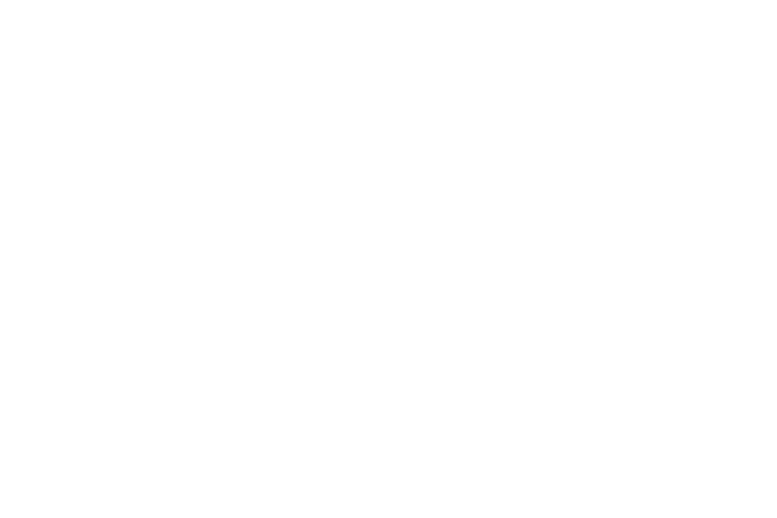

<IPython.core.display.Javascript object>


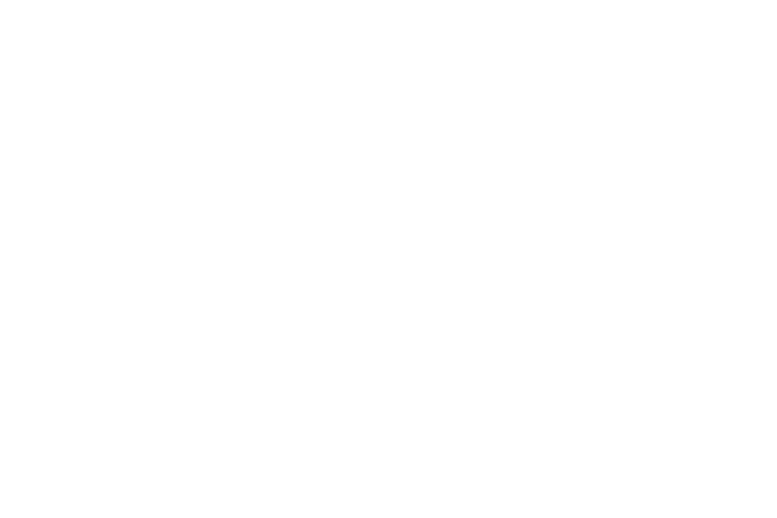

In [60]:
# from mpl_toolkits.mplot3d import Axes3D
% matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_points["Points:0"],grouped_points["Points:1"],grouped_points["Points:2"], s=1, c=grouped_points.index)
ax.view_init(100, 90)
plt.show()

In [61]:
# plotly visualization

In [62]:
distinct_labels = []
for label in labels:
    distinct_labels.append(label%256)

In [63]:
trace_db = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=np.array(distinct_labels).astype(np.float),
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [64]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_db,1,1)
fig['layout'].update(title = "DBScan Clusters")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='db_clustering')

In [65]:
distinct_labels = []
for label in grouped_points.index:
    distinct_labels.append(label%256)

In [66]:
trace_centers = go.Scatter3d(x=grouped_points["Points:1"], y=grouped_points["Points:0"],z=grouped_points["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=np.array(distinct_labels).astype(np.float),
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [67]:
# change distinct labels to labels created by clustering the normals
distinct_labels = []
for label in labels:
    if label==0:
        distinct_labels.append("red")
    else:
        distinct_labels.append("blue")



trace_centers = go.Scatter3d(x=grouped_points["Points:1"], y=grouped_points["Points:0"],z=grouped_points["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=distinct_labels,
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [68]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_centers,1,1)
fig['layout'].update(title = "Centers of DBScan Clusters")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='db_centers')

In [69]:
# how do I split the two layers???

In [70]:
# how do I find the centers of the lenses???

In [71]:
# fix the colormap

In [72]:
# should I average curvature over the cluster???
# display the curvature of the reduced dataset

In [73]:
# I need to better use the curvature information: not just to subset the points

#### Normals exploration

In [74]:
points.head()

,Normals:0,Normals:1,Normals:2,Gauss_Curvature,Points:0,Points:1,Points:2
0,0.068430,-0.18248,-0.98083,0.020666,694.00,334.33,9.0000
1,0.032669,-0.19601,-0.98006,0.011540,693.00,334.00,9.0000
2,0.066419,-0.13284,-0.98891,0.010068,694.00,335.00,8.8889
3,-0.092265,0.13753,-0.98619,0.011527,420.00,314.00,10.9620
4,-0.112720,0.13526,-0.98438,0.013171,419.67,314.00,11.0000


Average normals over a region. We cannot simply average the vectors because they are attached to different points.

I do not have the surface here.

Can I do something with the volume??

Cluster the normals.

In [75]:
points.columns

Index(['Normals:0', 'Normals:1', 'Normals:2', 'Gauss_Curvature', 'Points:0',
       'Points:1', 'Points:2'],
      dtype='object')

<IPython.core.display.Javascript object>


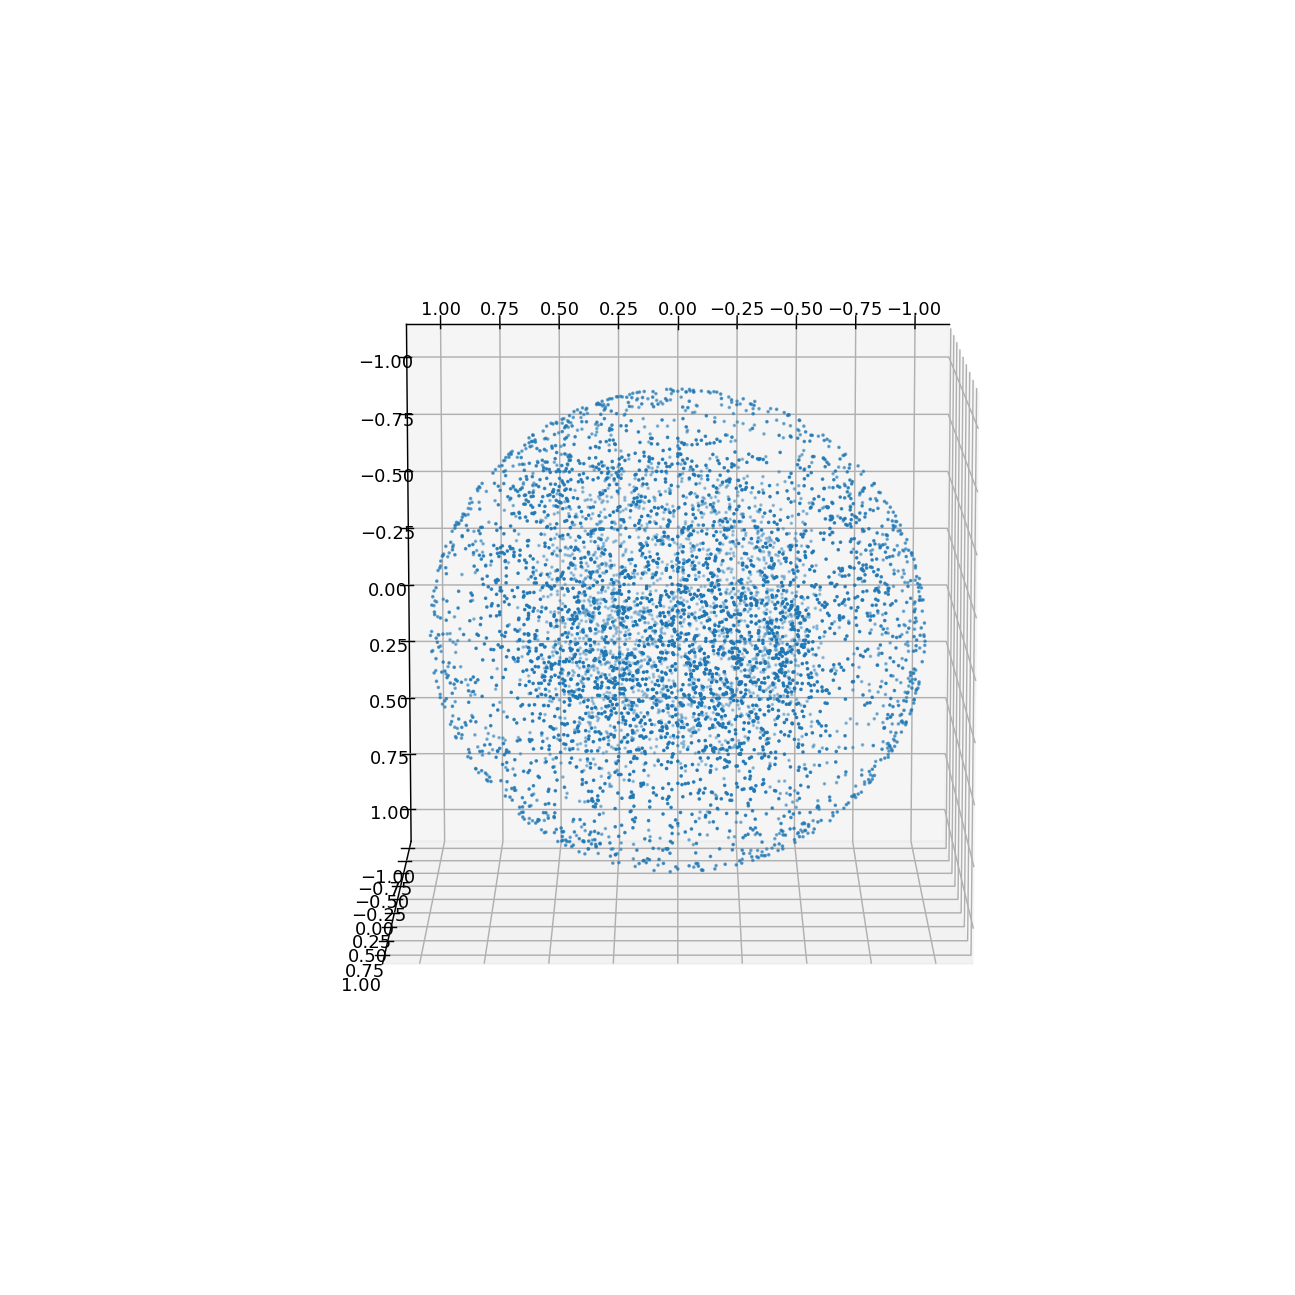

In [76]:
# visualize the normals as points in 3D:


% matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_subset["Normals:0"],points_subset["Normals:1"],points_subset["Normals:2"], s=1)
ax.view_init(100, 90)
plt.show()
plt.draw()

They are all normalized.This means that some of them are really small and noisy, but they equally matter in the above presentation. 

In [77]:
# Attempt 1: split into half and color nodes based on this splitting.

Do surface  remeshing and then calculate normals. How do I go back to the original surface after that?

Only look at normals at the corner points. For that I use `points_subset` variable.

Plot quiver plot.

How to identify lenses???

A point that is equally distant from the

Procedure to connect the points?

For each point find 3 nearest neigbors that are of the same radius.

If I have two surfaces: the nearest neighbor may be from the other surface.
Pair points by their nearest neighbors. Based on the distance,


In [80]:
trace_centers.shape

In [81]:
grouped_points.shape

(1329, 7)

Let's average the normals by group.

In [82]:
grouped_points.head()

,Normals:0,Normals:1,Normals:2,Gauss_Curvature,Points:0,Points:1,Points:2
label,,,,,,,
-1,-0.007766,-0.055294,0.204687,0.036722,604.907031,437.633205,108.557271
0,-0.162985,-0.361420,-0.917975,0.036892,683.900000,454.950000,14.000000
1,0.029140,-0.429430,-0.892460,0.031858,459.460000,446.000000,16.000000
2,0.357968,-0.080959,-0.781416,0.040650,457.572000,293.800000,17.439400
3,0.078603,-0.207668,-0.946018,0.043528,711.400000,352.600000,17.206600


<IPython.core.display.Javascript object>


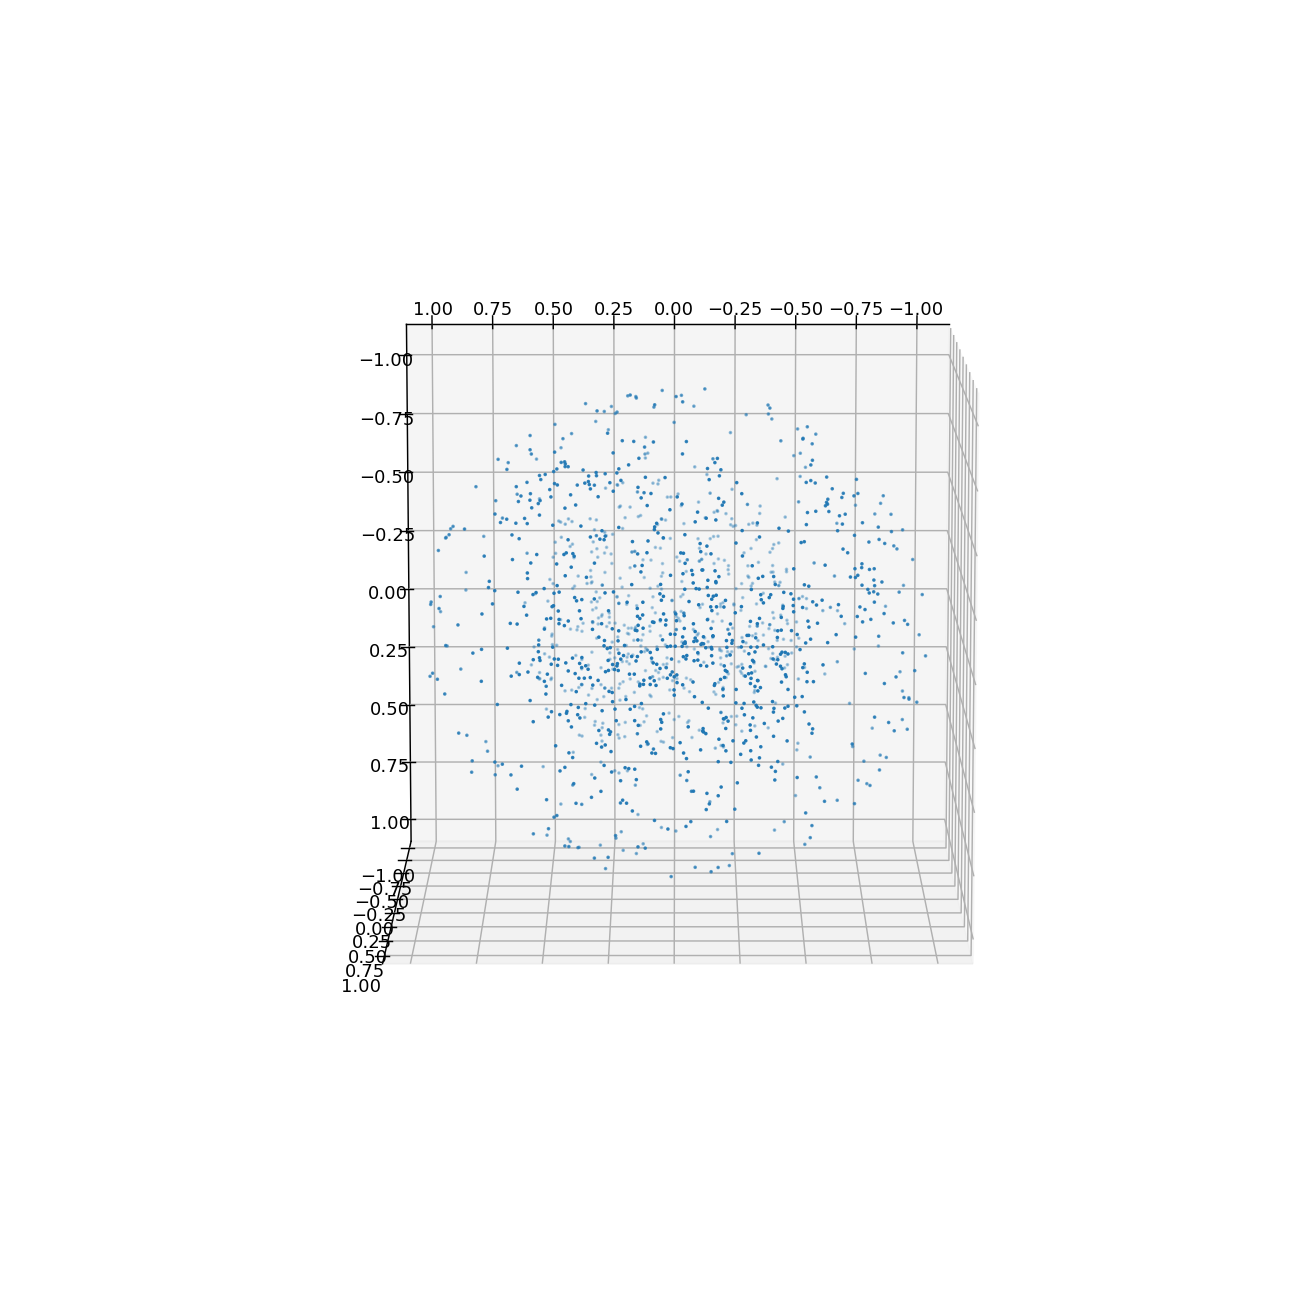

In [83]:
# visualize the normals as points in 3D, these are the grouped normals so they are much sparsers and easier to interpret:


% matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_points["Normals:0"],grouped_points["Normals:1"],grouped_points["Normals:2"], s=1)
ax.view_init(100, 90)
plt.show()
plt.draw()

<IPython.core.display.Javascript object>


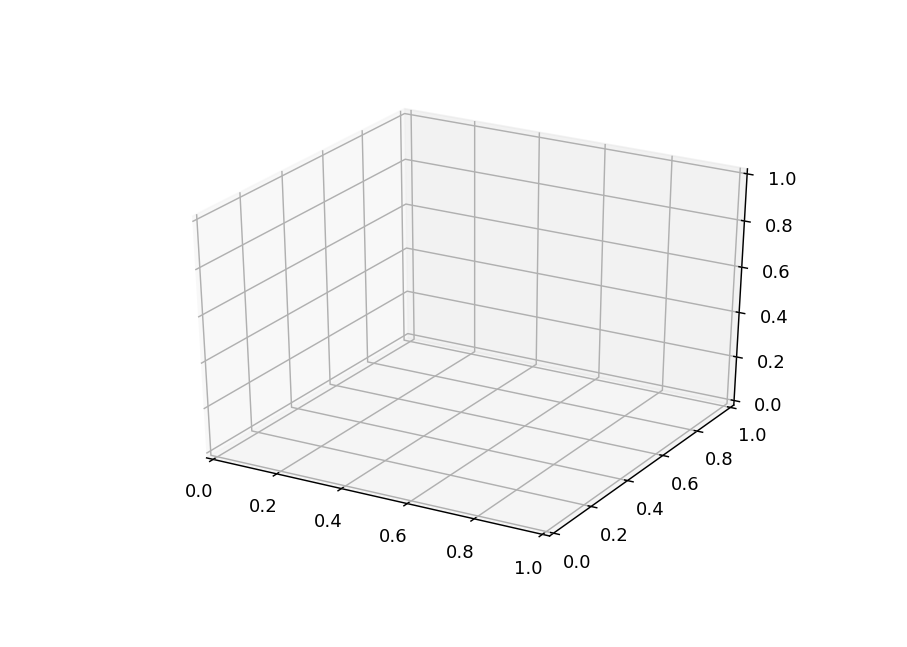

ValueError: Invalid RGBA argument: -1

In [84]:
# run kmeans on the normals:
kmeans = KMeans(n_clusters = 2,random_state=0).fit(grouped_points.iloc[:,:3])
surf_labels = kmeans.labels_
# kmeans clustering
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(grouped_points["Normals:0"]), np.array(grouped_points["Normals:1"]),np.array(grouped_points["Normals:2"]), s=0.5,c = labels)
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(0,90)
plt.title('K-Means Clusters')
plt.show()

Ok, they look well separated. Now let's plot the original points with separation.

<IPython.core.display.Javascript object>


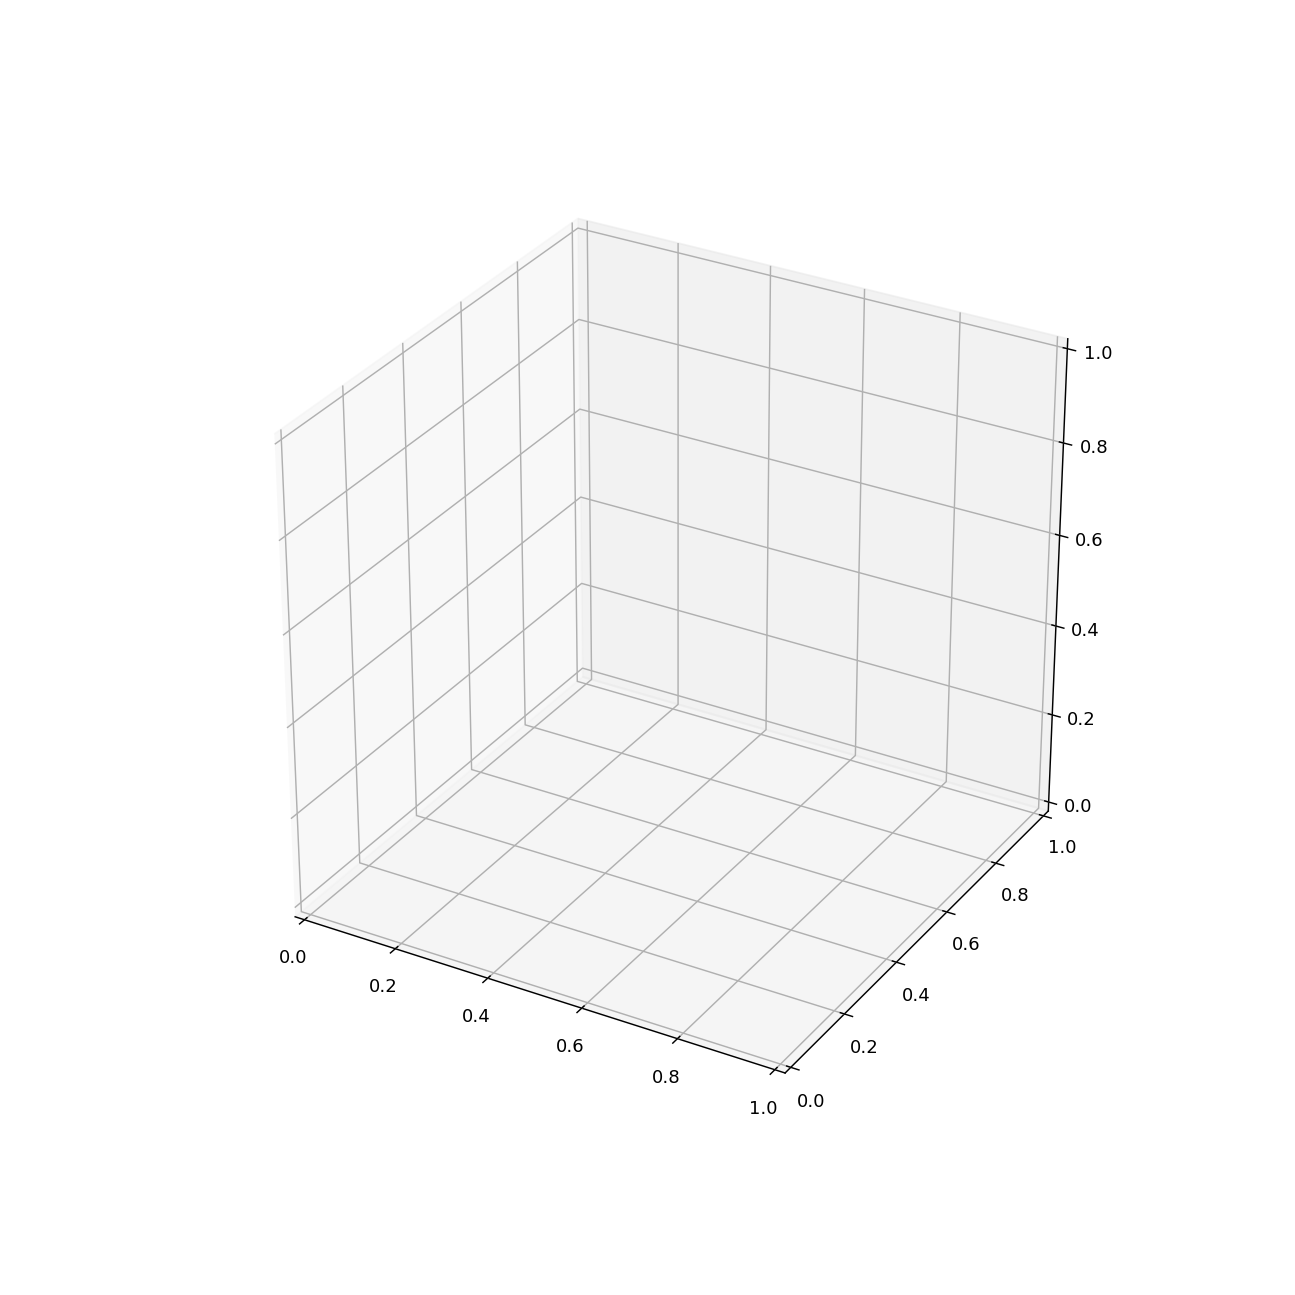

ValueError: Invalid RGBA argument: -1

In [85]:

# kmeans clustering
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(grouped_points["Points:0"]), np.array(grouped_points["Points:1"]),np.array(grouped_points["Points:2"]), s=1, cmap = 'viridis',c = labels)
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(100, 90)
plt.title('K-Means Clusters')
plt.show()

In [86]:
# change distinct labels to labels created by clustering the normals
distinct_labels = []
for label in labels:
    if label==0:
        distinct_labels.append("red")
    else:
        distinct_labels.append("blue")



trace_centers = go.Scatter3d(x=grouped_points["Points:1"], y=grouped_points["Points:0"],z=grouped_points["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=distinct_labels,
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [87]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_centers,1,1)
fig['layout'].update(title = "Surface Separation")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='db_centers')

Yay, the normals helped us separate the surfaces! Now we can plot the upper layer points individually.

In [88]:
# subsetting the points of the outer surface
points_out = np.array(grouped_points)[~surf_labels.astype('bool'),:]

In [89]:
# change distinct labels to labels created by clustering the normals


trace_centers = go.Scatter3d(x=points_out[:,4], y=points_out[:,5],z=points_out[:,6],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color="red",
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [90]:
 fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_centers,1,1)
fig['layout'].update(title = "Surface Separation")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='db_centers')

In [91]:
points_out.shape

(529, 7)

In [92]:
grouped_points.columns

Index(['Normals:0', 'Normals:1', 'Normals:2', 'Gauss_Curvature', 'Points:0',
       'Points:1', 'Points:2'],
      dtype='object')

Now maybe we should find closest three members?

But we want them of the same distance.

* Find first three neigbors
* Calculate distances (we have the distances ranked)
* If some distance is bigger by a threshold from the other distances, do not create an edge, otherwise, connect

Matrix of distance

In [95]:
# finding the nearest neighbors
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(points_out)
distances, indices = nbrs.kneighbors(points_out)

In [96]:
# creating the nearest neighbor graph
G = nbrs.kneighbors_graph(points_out, mode='distance').toarray()

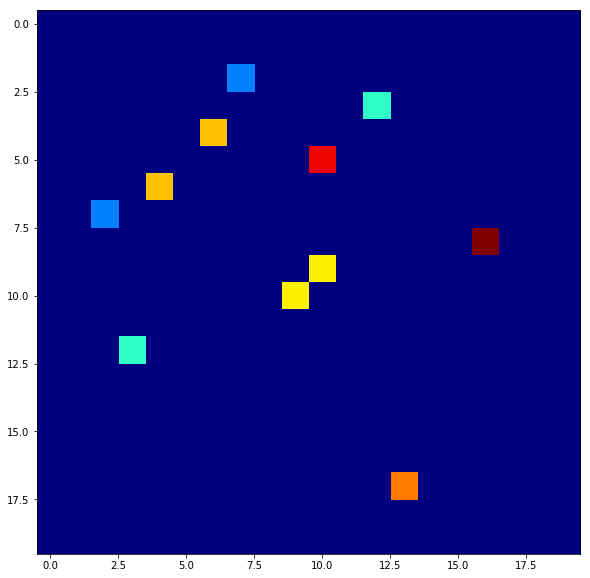

In [99]:
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(G[:20,:20],cmap = 'jet')

In [108]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(points_out)
distances, indices = nbrs.kneighbors(points_out)

(-0.5, 528.5, 2.5, -0.5)

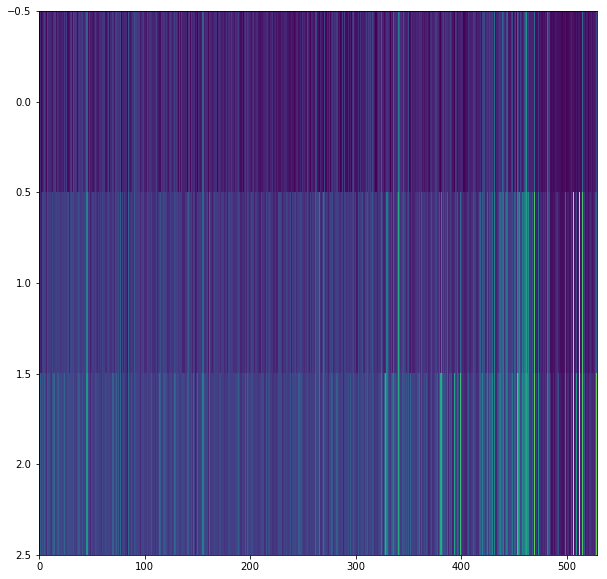

In [117]:
plt.figure(figsize = (10,10))
plt.imshow(distances[:,1:].T)
plt.axis('tight')


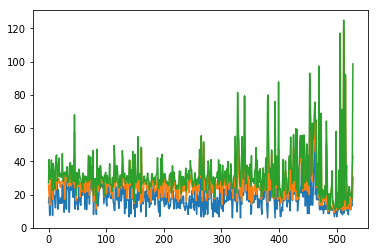

In [118]:
plt.plot(distances[:,1:])